# Exploring Spotify Daily Top 200 Charts for 2022

Data for 50 regions (global and 49 countries) was scraped from the Spotify Charts website using the `download_charts.py` and `combine_charts.py` scripts (they can be found in the `cli-scripts` folder).

In [1]:
import pandas as pd
from helpers.data import create_data_path

In [2]:
charts = pd.read_parquet(create_data_path('top200_2022.parquet'))

In [3]:
charts

,date,region_code,track_id,pos,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams
0,2022-01-01,ae,5PjdY0CKGZdEuoNab3yDmX,1,"The Kid LAROI, Justin Bieber",STAY (with Justin Bieber),Columbia,1,1,177,8656
1,2022-01-01,ae,5Z9KJZvQzH6PFmb8SNkxuk,2,"Lil Nas X, Jack Harlow",INDUSTRY BABY (feat. Jack Harlow),Columbia,2,4,163,7871
2,2022-01-01,ae,02MWAaffLxlfxAUY7c5dvx,3,Glass Animals,Heat Waves,Polydor Records,2,3,389,7743
3,2022-01-01,ae,2Xr1dTzJee307rmrkt8c0g,4,CKay,love nwantiti (ah ah ah),Chocolate City Music,2,5,116,7239
4,2022-01-01,ae,1r9xUipOqoNwggBpENDsvJ,5,"Imagine Dragons, JID, Arcane, League of Legends",Enemy (with JID) - from the series Arcane Leag...,KIDinaKORNER/Interscope Records,5,9,60,7065
...,...,...,...,...,...,...,...,...,...,...,...
5098013,2022-12-31,za,7IQbOBVEQTb3lGNNi1e71i,196,"Focalistic, Mellow & Sleazy, M.J, Pabi Cooper",Tsela Tse Nyane,18 Area Holdings,21,102,44,7673
5098014,2022-12-31,za,1JSTJqkT5qHq8MDJnJbRE1,197,The Police,Every Breath You Take,Polydor Records,56,-1,81,7662
5098015,2022-12-31,za,39sSsu4g7vjVOax8DU98NX,198,"Kabza De Small, Nkosazana Daughter, Murumba Pitch",Isoka (feat. Nkosazana Daughter & Murumba Pitch),Piano Hub,21,-1,103,7651
5098016,2022-12-31,za,2GAhgAjOhEmItWLfgisyOn,199,SZA,Low,Top Dawg Entertainment/RCA Records,22,85,21,7641


In [4]:
region_chart_entry_counts = (
    charts.groupby("region_code").size().sort_values(ascending=False)
)
region_chart_entry_counts

region_code
jp    73000
pe    73000
hn    73000
hu    73000
ie    73000
      ...  
ve    55800
pk    45006
ee    39477
is    34222
lu    15562
Length: 73, dtype: int64

<Axes: title={'center': 'Number of chart entries per region'}, xlabel='region_code'>

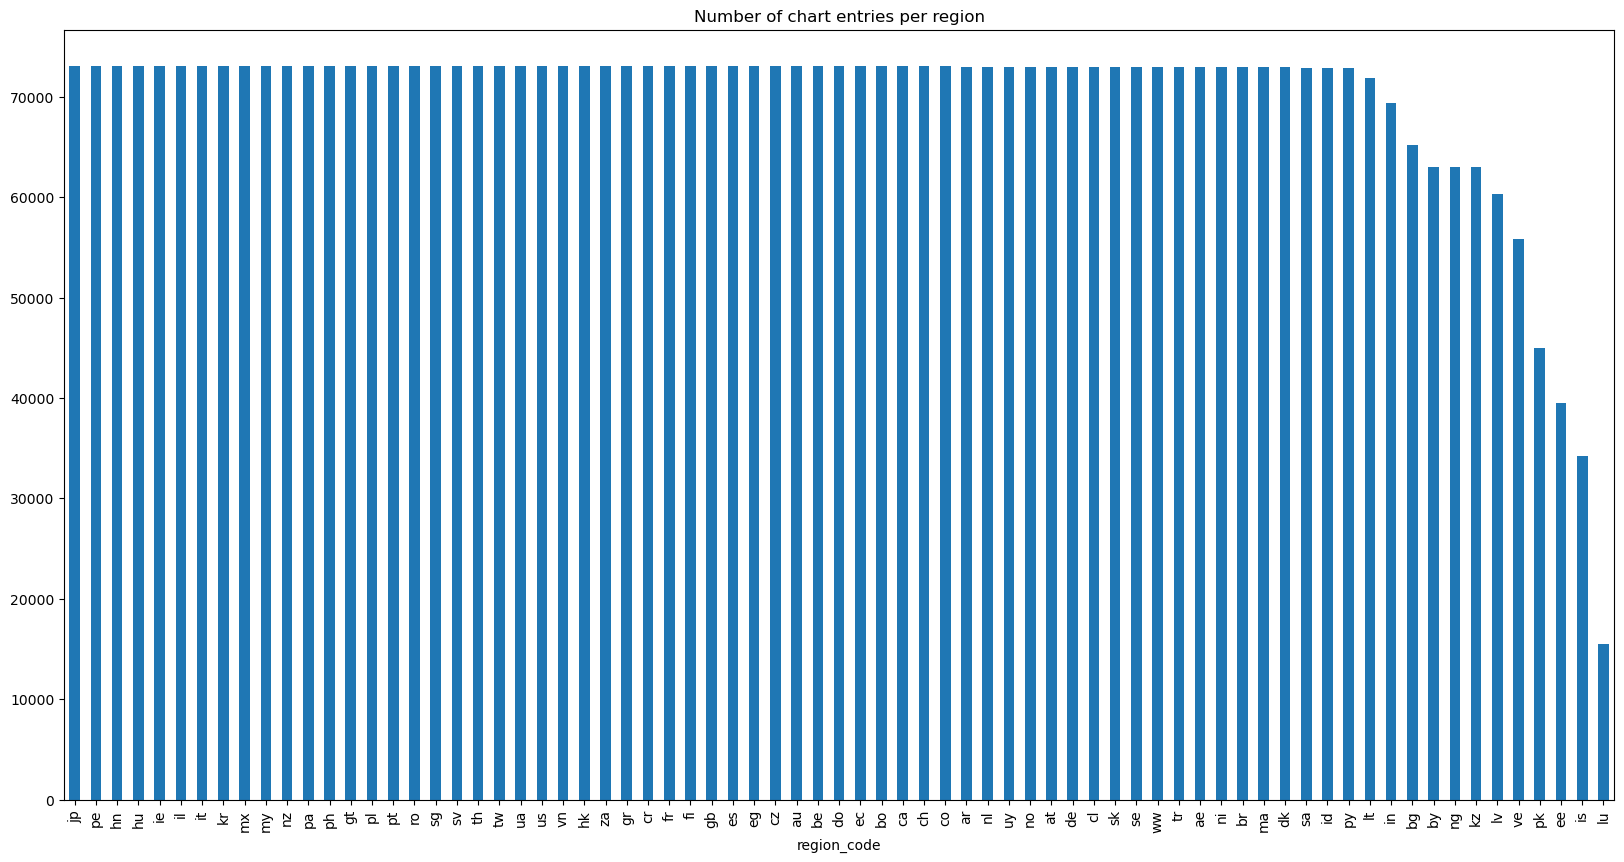

In [5]:
from matplotlib import pyplot as plt
region_chart_entry_counts.plot.bar(figsize=(20, 10), title="Number of chart entries per region")

Looks like data completeness is good for most of the countries :)

<Axes: title={'center': 'Number of days with chart data by region'}, xlabel='region_code'>

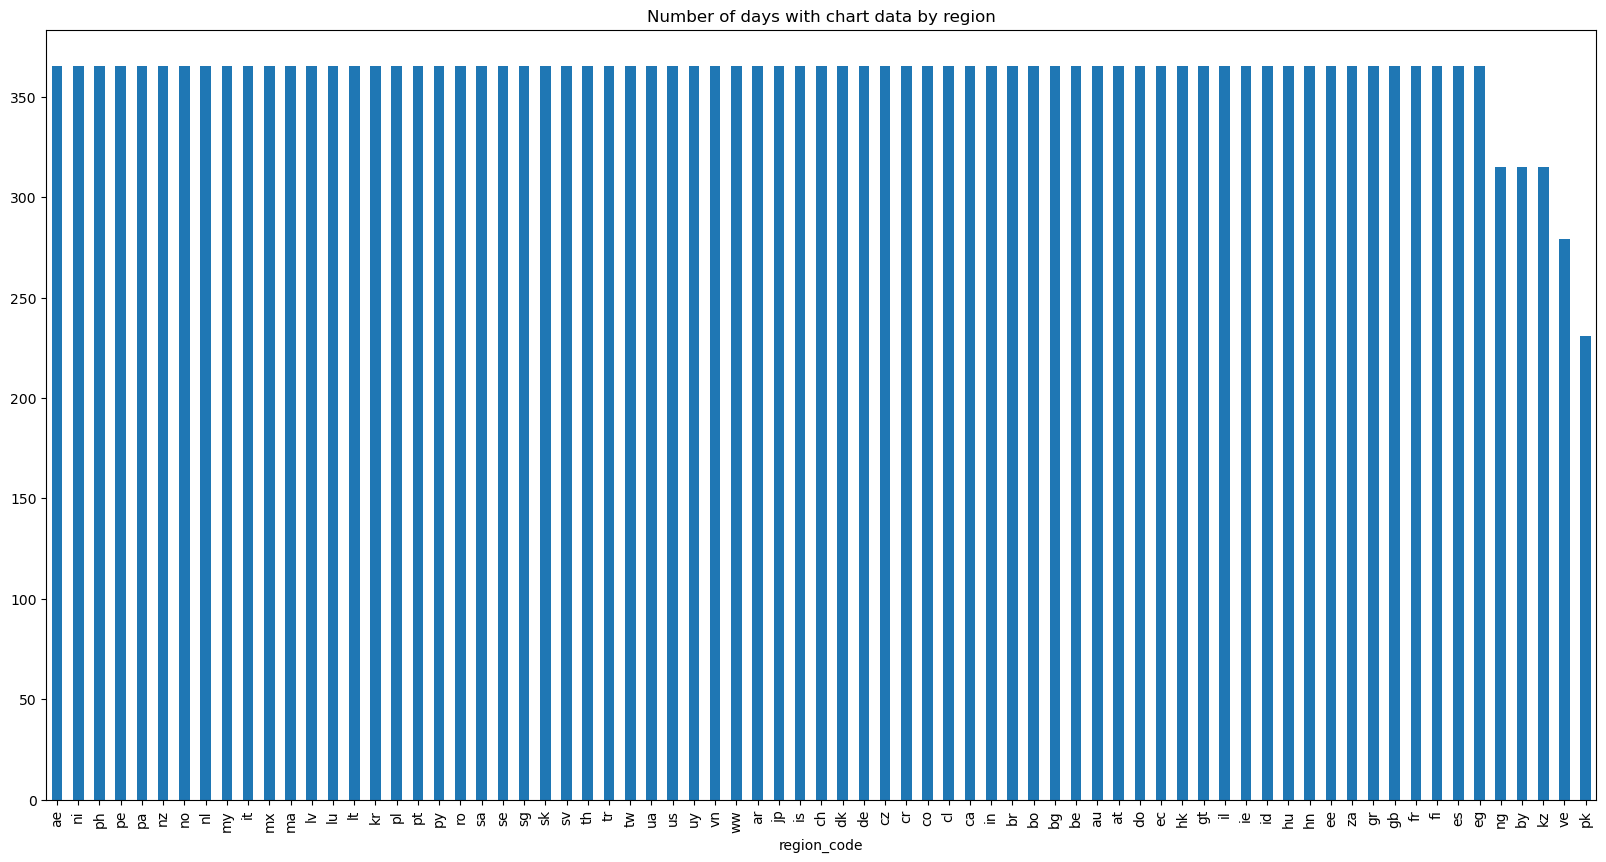

In [6]:
days_with_data_by_region = charts.groupby("region_code").date.nunique().sort_values(ascending=False)
days_with_data_by_region.plot.bar(figsize=(20, 10), title="Number of days with chart data by region")

In [7]:
complete_data_chart_entry_count = 365 * 200
complete_data_chart_entry_count

73000

In [8]:
regions_with_complete_data = region_chart_entry_counts[
    region_chart_entry_counts == complete_data_chart_entry_count
].index
len(regions_with_complete_data)

42

For our further analysis, let's only look at *countries* that have almost complete data (at least 99% of the 'optimal' number of chart entries AND some chart data for every day of 2022)

In [9]:
regions_with_almost_complete_data = region_chart_entry_counts[
    region_chart_entry_counts >= complete_data_chart_entry_count * 0.99
].index.tolist()
len(regions_with_almost_complete_data)

61

In [10]:
regions_with_data_for_every_day = days_with_data_by_region[
    days_with_data_by_region == 365
].index.tolist()
len(regions_with_data_for_every_day)

68

In [11]:
regions_to_keep = set(regions_with_almost_complete_data).intersection(set(regions_with_data_for_every_day))
len(regions_to_keep)

61

In [12]:
countries_to_keep = regions_to_keep.copy()
countries_to_keep.discard("ww")
len(countries_to_keep)

60

In [13]:
country_charts = charts[charts.region_code.isin(countries_to_keep)]

## Estimating popularity of Spotify by market (country)

### Biggest markets by total number of streams of Daily Top 200 tracks for 2022

A simple approach is just summing up the number of streams for each country. This approach gives us a good idea for the absolute number of streams of the Top 200 for all countries with good data coverage (which we already identified before).

<Axes: title={'center': 'Top countries by streams'}, xlabel='region_code'>

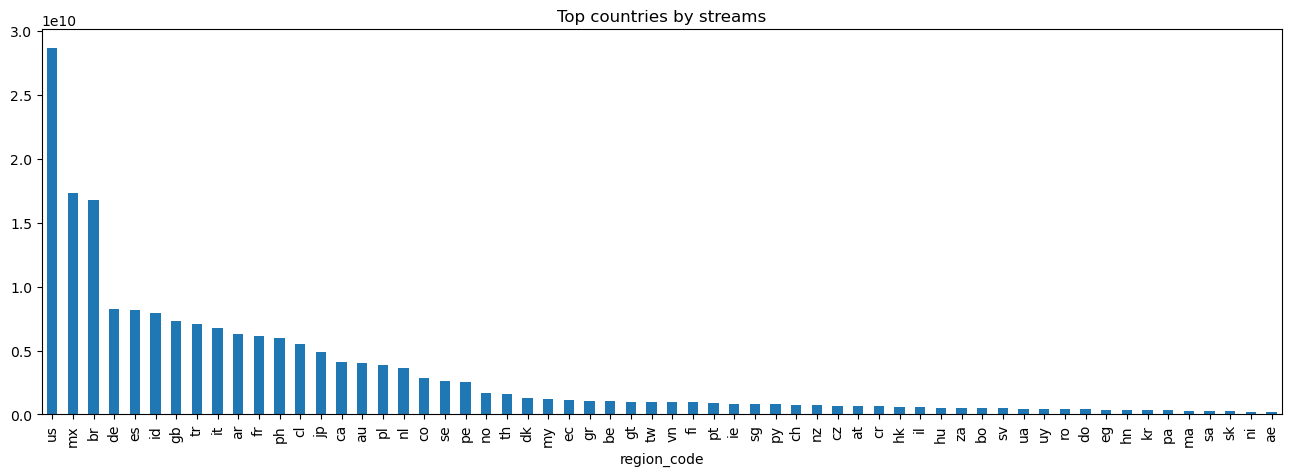

In [14]:
streams_by_region = country_charts.groupby("region_code").streams.sum()
streams_by_country = streams_by_region[streams_by_region.index != "ww"].sort_values(
    ascending=False
)

streams_by_country.sort_values(ascending=False).plot(
    kind="bar", figsize=(16, 5), title=f"Top countries by streams"
)

### Estimating markets where Spotify is most popular

Probably it is smarter to identify "important" markets by putting the number of total streams in relation to the total population of each country. Unfortunately, no data is available for 2022 yet (as of June 21st, 2023). So, I use the data from the year 2021.

In [15]:
population = pd.read_csv(create_data_path("country_population.csv"), skiprows=3)[
    ["Country Code", "2021"]
].rename(columns={"Country Code": "alpha3", "2021": "population"})
population.head()

,alpha3,population
0,ABW,106537.0
1,AFE,702976832.0
2,AFG,40099462.0
3,AFW,478185907.0
4,AGO,34503774.0


In [16]:
country_codes = pd.read_csv(create_data_path("country_codes.csv"))[
    ["alpha-3", "alpha-2"]
].rename(columns={"alpha-3": "alpha3", "alpha-2": "alpha2"})
country_codes.head()

,alpha3,alpha2
0,AFG,AF
1,ALA,AX
2,ALB,AL
3,DZA,DZ
4,ASM,AS


In [17]:
country_population = pd.merge(country_codes, population, on='alpha3')
country_population.head()

,alpha3,alpha2,population
0,AFG,AF,40099462.0
1,ALB,AL,2811666.0
2,DZA,DZ,44177969.0
3,ASM,AS,45035.0
4,AND,AD,79034.0


In [18]:
streams_by_region.head()

region_code
ae     188758277
ar    6293552448
at     683468574
au    4060833608
be    1048317818
Name: streams, dtype: int64

In [19]:
region_names_and_codes = pd.read_csv(create_data_path("region_names_and_codes.csv"))[
    ["name", "code"]
].rename(columns={"code": "alpha2", "name": "region"})
region_names_and_codes.alpha2 = (
    region_names_and_codes.alpha2.str.upper()
)  # convert to uppercase to match existing data
region_names_and_codes.head()

,region,alpha2
0,Global,WW
1,Argentina,AR
2,Australia,AU
3,Austria,AT
4,Belarus,BY


In [20]:
len(region_names_and_codes[region_names_and_codes.alpha2.str.lower().isin(countries_to_keep)]) == len(countries_to_keep)

True

In [21]:
streams_by_country.index = (
    streams_by_country.index.str.upper()
)  # country codes are upper case in the country codes dataset; adapt the streams_by_country index to match
population_and_streams = pd.merge(
    country_population,
    streams_by_country,
    left_on="alpha2",
    right_index=True,
    how="right",
).reset_index(drop=True)

In [22]:
population_and_streams.head()

,alpha3,alpha2,population,streams
0,USA,US,331893745.0,28692944850
1,MEX,MX,126705138.0,17358869887
2,BRA,BR,214326223.0,16775134005
3,DEU,DE,83196078.0,8285930091
4,ESP,ES,47415750.0,8140294286


In [32]:
len(population_and_streams)

60

In [23]:
population_and_streams[population_and_streams.population.isna()]

,alpha3,alpha2,population,streams
29,NaN,TW,NaN,983876865


No data seems to be available for Taiwan (code `TW`). I looked up the data manually [here](https://www.census.gov/data-tools/demo/idb/#/country?COUNTRY_YEAR=2021&COUNTRY_YR_ANIM=2021&FIPS_SINGLE=TW). So let's just use that number (23,572,052).

In [24]:
population_and_streams.loc[population_and_streams.alpha2 == 'TW', 'population'] = 23572052

In [34]:
len(population_and_streams) == len(countries_to_keep)

True

In [25]:
population_and_streams = pd.merge(region_names_and_codes, population_and_streams, on='alpha2').rename(columns={'region': 'country'})
population_and_streams.head()

,country,alpha2,alpha3,population,streams
0,Argentina,AR,ARG,45808747.0,6293552448
1,Australia,AU,AUS,25688079.0,4060833608
2,Austria,AT,AUT,8955797.0,683468574
3,Belgium,BE,BEL,11592952.0,1048317818
4,Bolivia,BO,BOL,12079472.0,478744319


In [27]:
population_and_streams['streams_vs_pop'] = population_and_streams.streams / population_and_streams.population

In [28]:
population_and_streams.head()

,country,alpha2,alpha3,population,streams,streams_vs_pop
0,Argentina,AR,ARG,45808747.0,6293552448,137.387570
1,Australia,AU,AUS,25688079.0,4060833608,158.082417
2,Austria,AT,AUT,8955797.0,683468574,76.315773
3,Belgium,BE,BEL,11592952.0,1048317818,90.427168
4,Bolivia,BO,BOL,12079472.0,478744319,39.632885


<Axes: title={'center': 'Top countries (ratio of total streams of chart tracks to population)'}, xlabel='country'>

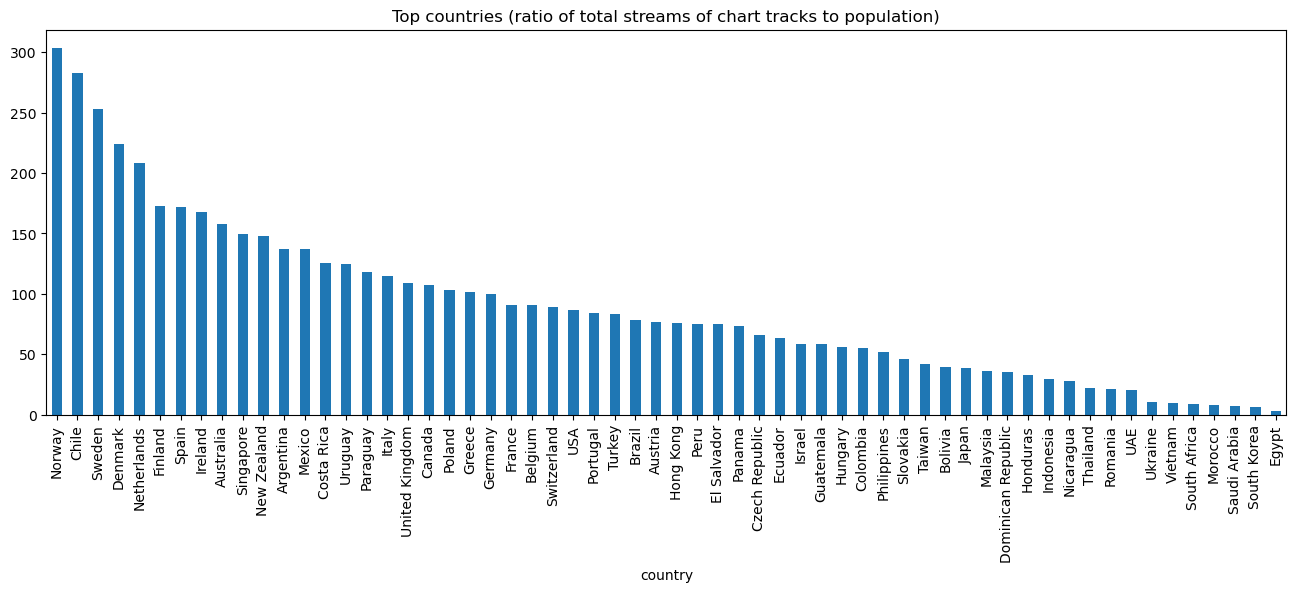

In [29]:
population_and_streams.set_index('country').streams_vs_pop.sort_values(ascending=False).plot(kind='bar', figsize=(16, 5), title=f'Top countries (ratio of total streams of chart tracks to population)')

This ratio between total Spotify streams and total population for a given country might not be the best metric for 'popularity', but it does produce interesting insights. 

We notice that the ratio of Spotify streams (compared to the total population) is biggest in Norway. The number is also quite big for Sweden (Spotify's 'country of origin') and Denmark. The popularity of Spotify in Chile is certainly surprising.

### Estimating most 'financially relevant' markets

Of course, smaller markets (like Austria with only around 9 mio. total population) are much less relevant for Spotify in terms of number of paying customers and therefore income compared to bigger countries (like the US with its more than 300 mio. inhabitants). So, let's try to find a metric for measuring 'financial relevance' of a particular market/country.

Let's assume that the total number of streams of Top 200 tracks also correlates with the overall popularity of Spotify for any given country.

Then, we can just use the ratio of total streams and population for each country that we already calculated above and multiply it with the population of each country. If we assume that more streams also means more money for Spotify, this would give us a rough idea of the relevance of this country for Spotify.

In [30]:
population_and_streams['financial_relevance'] = population_and_streams.streams_vs_pop * population_and_streams.population
population_and_streams.financial_relevance = population_and_streams.financial_relevance / population_and_streams.financial_relevance.max()

<Axes: title={'center': "Top countries by estimated 'financial relevance' (ratio between total streams of chart tracks and population * population, normalized by max)"}, xlabel='country'>

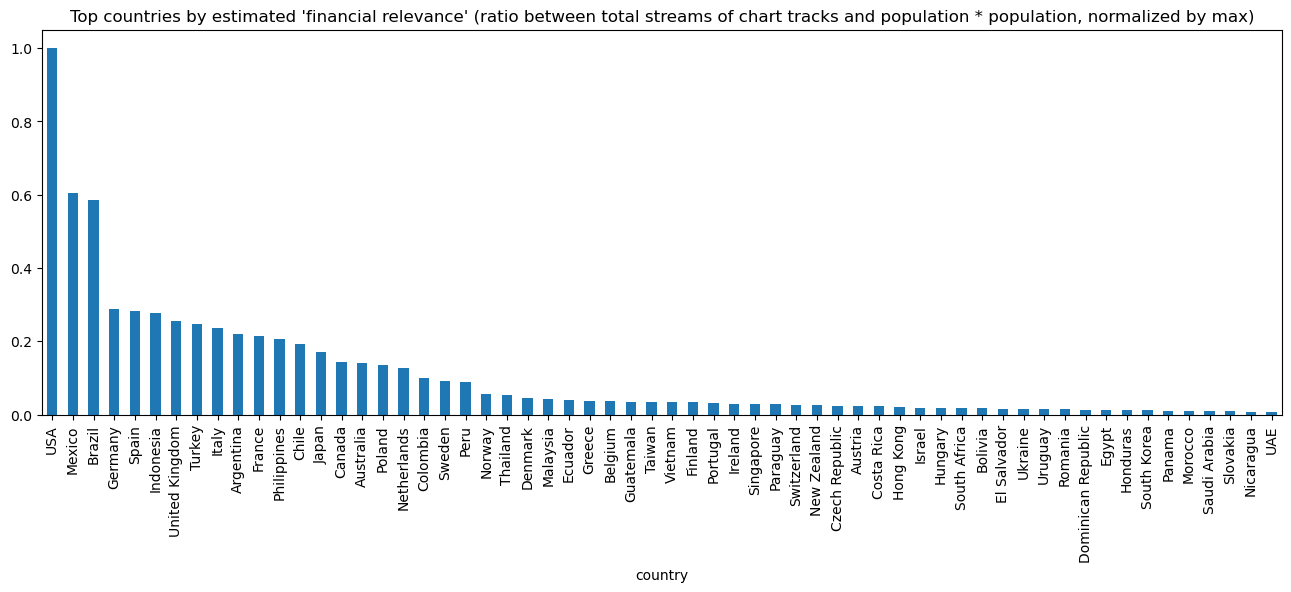

In [31]:
population_and_streams.set_index("country").financial_relevance.sort_values(
    ascending=False
).plot(
    kind="bar",
    figsize=(16, 5),
    title=f"Top countries by estimated 'financial relevance' (ratio between total streams of chart tracks and population * population, normalized by max)",
)

Here, the US again appear as most relevant! There's one more caveat though: some countries (like India) have significantly lower GDP compared to first world countries. Furthermore, it makes a difference what percentage of customers pays for Spotify Premium AND how much Spotify Premium costs in that particular country.

So, this metric is maybe not really that suitable for estimating financial relevance. But still, it might give us a rough idea of where Spotify is 'biggest' (in terms of total number of people using the service).